# Hourly Forecasting Carbon Intensity using MLP #

## Importing modules ##

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from joblib import Parallel, delayed
import sys, os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
# Add path to power_monitor
sys.path.append(os.path.abspath('../../LibreHardwareMonitor-net472'))
from power_monitor import PowerMonitor
# Dictionary to store execution times for each code block
execution_times = {}
power_stats = {}

## Processing data for hourly carbon intensity ##

In [5]:
with PowerMonitor(filename = 'full_MLP.csv') as pmon:
    start_time = time.time()

    df = pd.read_parquet('../../data/data_CI.parquet')
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df.set_index('DATETIME', inplace=True)

    # Resample to hourly means
    df_hourly = df['CARBON_INTENSITY'].resample('H').mean().reset_index()

    df_hourly['CARBON_INTENSITY'] = df_hourly['CARBON_INTENSITY'].interpolate(method='linear')

    # Check data
    print("Hourly Data Head:")
    print(df_hourly.head())
    print("\nShape:", df_hourly.shape)

    execution_times['Data Processing'] = time.time() - start_time
    print(f"Data Processing Time: {execution_times['Data Processing']:.4f} seconds")
    execution_times['Data Processing'] = time.time() - start_time
power_stats["Data Processing"] = pmon.stats()

Hourly Data Head:
             DATETIME  CARBON_INTENSITY
0 2015-01-01 00:00:00             350.0
1 2015-01-01 01:00:00             350.5
2 2015-01-01 02:00:00             324.5
3 2015-01-01 03:00:00             320.0
4 2015-01-01 04:00:00             322.5

Shape: (96251, 2)
Data Processing Time: 0.1524 seconds


C:\Users\tianw\AppData\Local\Temp\ipykernel_12048\3817710017.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['CARBON_INTENSITY'].resample('H').mean().reset_index()


## Feature Engineering for Hourly Data ##

In [6]:
with PowerMonitor(filename = 'full_MLP.csv') as pmon:
    start_time = time.time()
    def compute_single_feature(data, feat_type, window):
        """Function to be run in a separate thread."""
        if feat_type == 'lag':
            return pd.Series(data['CARBON_INTENSITY'].shift(window), name=f'lag_{window}')
        elif feat_type == 'rolling':
            # Shift(1) to avoid data leakage
            return pd.Series(data['CARBON_INTENSITY'].shift(1).rolling(window=window).mean(), 
                            name=f'rolling_mean_{window}')

    def create_hourly_features_parallel(data, n_jobs=-1):
        df = data.copy()
        
        # 1. Time-based features (These are extremely fast/vectorized, keep on main thread)
        df['hour'] = df['DATETIME'].dt.hour
        df['day_of_week'] = df['DATETIME'].dt.dayofweek
        df['month'] = df['DATETIME'].dt.month
        df['day_of_year'] = df['DATETIME'].dt.dayofyear
        df['year'] = df['DATETIME'].dt.year
        
        # 2. Define tasks for parallel execution
        # Format: (type, window_size)
        tasks = [
            ('lag', 1), ('lag', 24), ('lag', 168),
            ('rolling', 24), ('rolling', 168)
        ]
        
        # 3. Execute tasks in parallel
        # n_jobs=-1 uses all available CPU cores
        feature_columns = Parallel(n_jobs=n_jobs)(
            delayed(compute_single_feature)(df[['CARBON_INTENSITY']], t, w) for t, w in tasks
        )
        
        # 4. Concatenate results back to the main dataframe
        df = pd.concat([df] + feature_columns, axis=1)
        
        return df.dropna()

    df_features = create_hourly_features_parallel(df_hourly, n_jobs=-1)
    print("Features Head:")
    print(df_features.head())

    execution_times['Feature Engineering'] = time.time() - start_time
    print(f"Feature Engineering Time: {execution_times['Feature Engineering']:.4f} seconds")

power_stats["Feature Engineering"] = pmon.stats()

Features Head:
               DATETIME  CARBON_INTENSITY  hour  day_of_week  month  \
168 2015-01-08 00:00:00             350.5     0            3      1   
169 2015-01-08 01:00:00             355.0     1            3      1   
170 2015-01-08 02:00:00             353.0     2            3      1   
171 2015-01-08 03:00:00             345.5     3            3      1   
172 2015-01-08 04:00:00             354.0     4            3      1   

     day_of_year  year  lag_1  lag_24  lag_168  rolling_mean_24  \
168            8  2015  335.5   412.5    350.0       405.416667   
169            8  2015  350.5   414.0    350.5       402.833333   
170            8  2015  355.0   402.5    324.5       400.375000   
171            8  2015  353.0   391.0    320.0       398.312500   
172            8  2015  345.5   387.5    322.5       396.416667   

     rolling_mean_168  
168        404.279762  
169        404.282738  
170        404.309524  
171        404.479167  
172        404.630952  
Feature Eng

## Train/Validation/Test Split ##

In [7]:
with PowerMonitor(filename = 'full_MLP.csv') as pmon:
    start_time = time.time()

    # Split: Train < 2024, Val = 2024, Test = 2025
    train_data = df_features[df_features['year'] < 2024].copy()
    val_data = df_features[df_features['year'] == 2024].copy()
    test_data = df_features[df_features['year'] == 2025].copy()

    feature_cols = [c for c in df_features.columns if c not in ['DATETIME', 'CARBON_INTENSITY', 'year']]

    X_train = train_data[feature_cols]
    y_train = train_data['CARBON_INTENSITY']

    X_val = val_data[feature_cols]
    y_val = val_data['CARBON_INTENSITY']

    X_test = test_data[feature_cols]
    y_test = test_data['CARBON_INTENSITY']

    print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

    execution_times['Data Splitting'] = time.time() - start_time
    print(f"Data Splitting Time: {execution_times['Data Splitting']:.4f} seconds")
power_stats["Data Splitting"] = pmon.stats()

Train samples: 78720, Val samples: 8784, Test samples: 8579
Data Splitting Time: 0.0144 seconds


## Data Scaling ##

In [8]:
with PowerMonitor(filename = 'full_MLP.csv') as pmon:
    start_time = time.time()

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Scale features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
    # We don't scale y_test for prediction, but for internal eval comparison if needed
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    execution_times['Scaling'] = time.time() - start_time
    print(f"Scaling Time: {execution_times['Scaling']:.4f} seconds")
power_stats["Scaling"] = pmon.stats()

Scaling Time: 0.0160 seconds


## Model Training ##

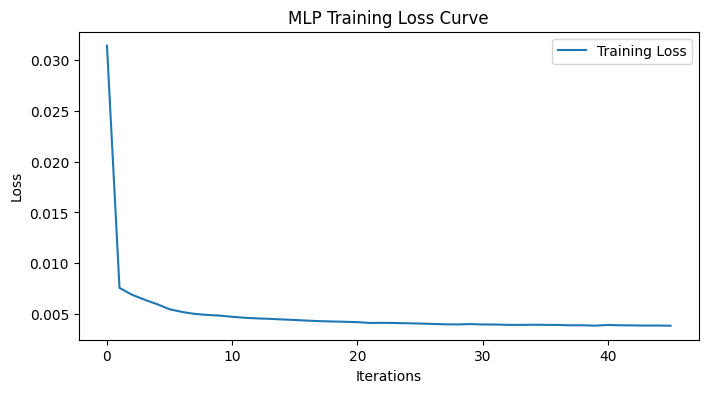

Model Training Time: 43.1404 seconds


In [9]:
with PowerMonitor(filename = 'full_MLP.csv') as pmon:
    start_time = time.time()

    # MLP Regressor Configuration
    # Using more capacity for hourly patterns
    mlp = MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        batch_size = 256,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=20,
    )

    history = mlp.fit(X_train_scaled, y_train_scaled)

    plt.figure(figsize=(8, 4))
    plt.plot(history.loss_curve_, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('MLP Training Loss Curve')
    plt.legend()
    plt.show()

    execution_times['Model Training'] = time.time() - start_time
    print(f"Model Training Time: {execution_times['Model Training']:.4f} seconds")
power_stats["Model Training"] = pmon.stats()


## Forecasting and Evaluation ##

Validation MAE: 6.34
Test MAE (2025): 6.48
Test MSE (2025): 73.05


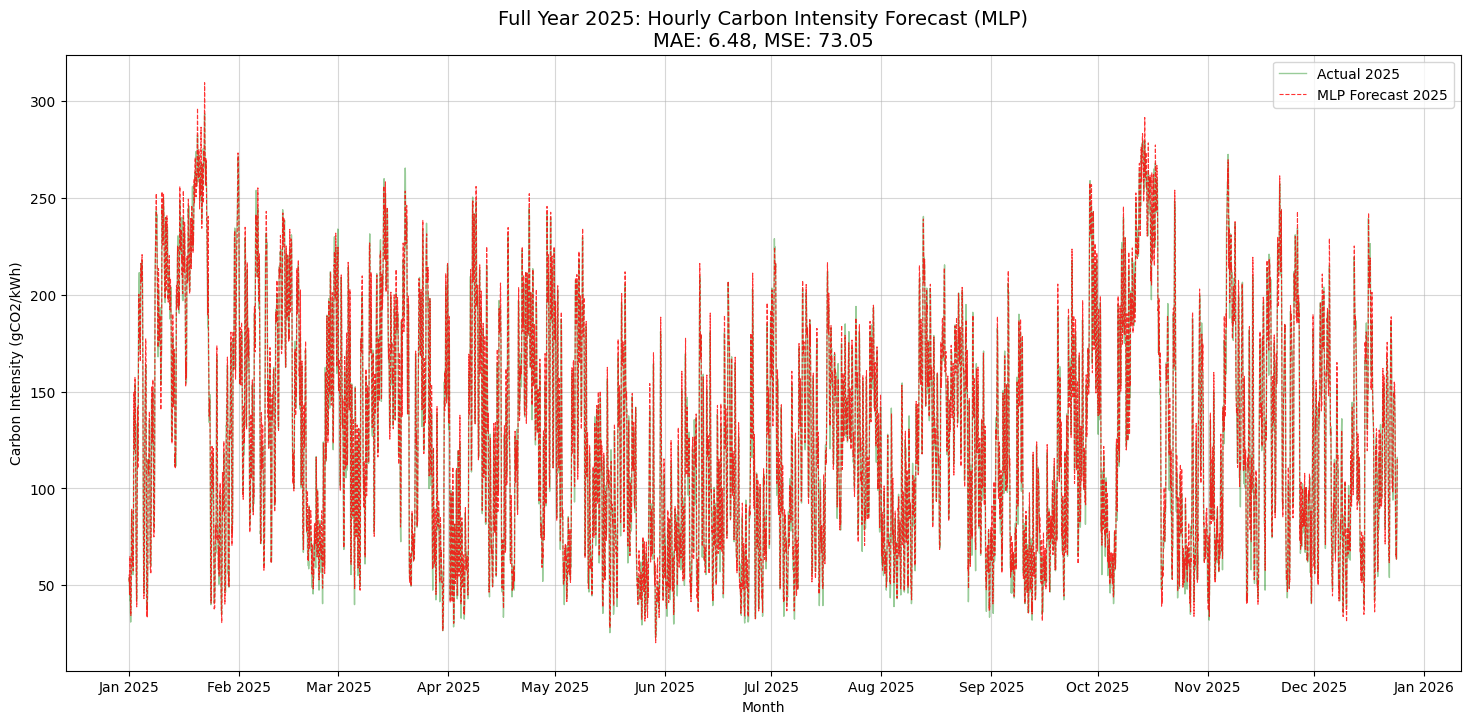

Forecasting Time: 0.5014 seconds


In [10]:
with PowerMonitor(filename = 'full_MLP.csv') as pmon:
    start_time = time.time()

    val_pred_scaled = mlp.predict(X_val_scaled)
    val_pred = scaler_y.inverse_transform(val_pred_scaled.reshape(-1, 1)).flatten()

    test_pred_scaled = mlp.predict(X_test_scaled)
    test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

    val_mae = mean_absolute_error(y_val, val_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_mse = mean_squared_error(y_test, test_pred)

    print(f"Validation MAE: {val_mae:.2f}")
    print(f"Test MAE (2025): {test_mae:.2f}")
    print(f"Test MSE (2025): {test_mse:.2f}")

    plt.figure(figsize=(18, 8))

    plt.plot(test_data['DATETIME'], y_test, label='Actual 2025', color='green', alpha=0.4, linewidth=1)

    plt.plot(test_data['DATETIME'], test_pred, label='MLP Forecast 2025', color='red', alpha=0.8, linestyle='--', linewidth=0.8)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.title(f'Full Year 2025: Hourly Carbon Intensity Forecast (MLP)\nMAE: {test_mae:.2f}, MSE: {test_mse:.2f}', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Carbon Intensity (gCO2/kWh)')
    plt.legend(loc='upper right')
    plt.grid(True, which='major', linestyle='-', alpha=0.5)

    plt.show()

    execution_times['Forecasting'] = time.time() - start_time
    print(f"Forecasting Time: {execution_times['Forecasting']:.4f} seconds")
power_stats["Forecasting"] = pmon.stats()

In [11]:
print("EXECUTION TIME SUMMARY")
total_time = 0
for task, duration in execution_times.items():
    print(f"{task}: {duration:.4f} seconds")
    total_time += duration
print(f"Total Execution Time: {total_time:.4f} seconds")

EXECUTION TIME SUMMARY
Data Processing: 0.1524 seconds
Feature Engineering: 2.0219 seconds
Data Splitting: 0.0144 seconds
Scaling: 0.0160 seconds
Model Training: 43.1404 seconds
Forecasting: 0.5014 seconds
Total Execution Time: 45.8464 seconds


In [12]:
with PowerMonitor(filename = 'full_MLP.csv') as pmon:
    start_time = time.time()
    if 'DATETIME' in df_hourly.columns:
        df_hourly["DATETIME"] = pd.to_datetime(df_hourly["DATETIME"])
        df_hourly = df_hourly.set_index("DATETIME")

    df_monthly = df_hourly.resample("ME").mean()

    def compute_lag(df, l):
        return pd.Series(df['CARBON_INTENSITY'].shift(l), name=f'lag_{l}')

    lags = [1, 2, 3, 6, 12]
    lag_results = Parallel(n_jobs=-1)(delayed(compute_lag)(df_monthly, l) for l in lags)

    # Concatenate and keep DATETIME as a column
    df_features = pd.concat([df_monthly] + lag_results, axis=1).reset_index()

    # Add year column
    df_features['year'] = df_features['DATETIME'].dt.year

    # Drop rows with NaN values (created by lag features)
    df_features = df_features.dropna()

    # Split the data BEFORE resampling to define the sets clearly
    train_data_raw = df_features[df_features['year'] < 2024].copy()
    valid_data_raw = df_features[df_features['year'] == 2024].copy()
    test_data_raw = df_features[df_features['year'] == 2025].copy()

    # FIX: Use 'on="DATETIME"' so resampling works with the column instead of the index
    train_data = train_data_raw.resample("ME", on="DATETIME").mean().reset_index()
    valid_data = valid_data_raw.resample("ME", on="DATETIME").mean().reset_index()
    test_data = test_data_raw.resample("ME", on="DATETIME").mean().reset_index()

    # Prepare Feature Matrix (X) and Target Vector (y)
    X_train = train_data.drop(columns=['DATETIME', 'CARBON_INTENSITY', 'year'], errors='ignore')
    y_train = train_data['CARBON_INTENSITY']

    X_val = valid_data.drop(columns=['DATETIME', 'CARBON_INTENSITY', 'year'], errors='ignore')
    y_val = valid_data['CARBON_INTENSITY']

    X_test = test_data.drop(columns=['DATETIME', 'CARBON_INTENSITY', 'year'], errors='ignore')
    y_test = test_data['CARBON_INTENSITY']

    execution_times["data split monthly"] = time.time() - start_time
power_stats["data split monthly"] = pmon.stats()

In [13]:
with PowerMonitor(filename = "full_MLP.csv") as pmon:
    start_time = time.time()
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Scale features based on training data only to avoid data leakage
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target (requires reshaping for the scaler)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    execution_times['Data Scaling monthly'] = time.time() - start_time
power_stats['Data Scaling monthly'] = pmon.stats()

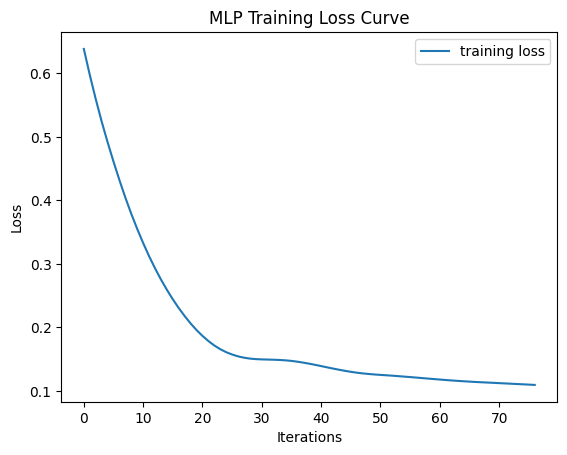

In [14]:
with PowerMonitor(filename = 'full_MLP.csv') as pmon:
    start_time = time.time()
    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 32), 
        activation='relu', 
        solver='adam', 
        max_iter=5000, 
        random_state=42,
        early_stopping=True,
        n_iter_no_change=50,
        verbose=False
    )

    # sklearn's MLPRegressor.fit does not accept eval_set; early_stopping=True will use an internal validation split
    historymlp = mlp.fit(X_train_scaled, y_train_scaled)

    plt.plot(historymlp.loss_curve_, label='training loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('MLP Training Loss Curve')
    plt.legend()
    execution_times['MLP Training monthly'] = time.time() - start_time
power_stats['MLP Training monthly'] = pmon.stats()

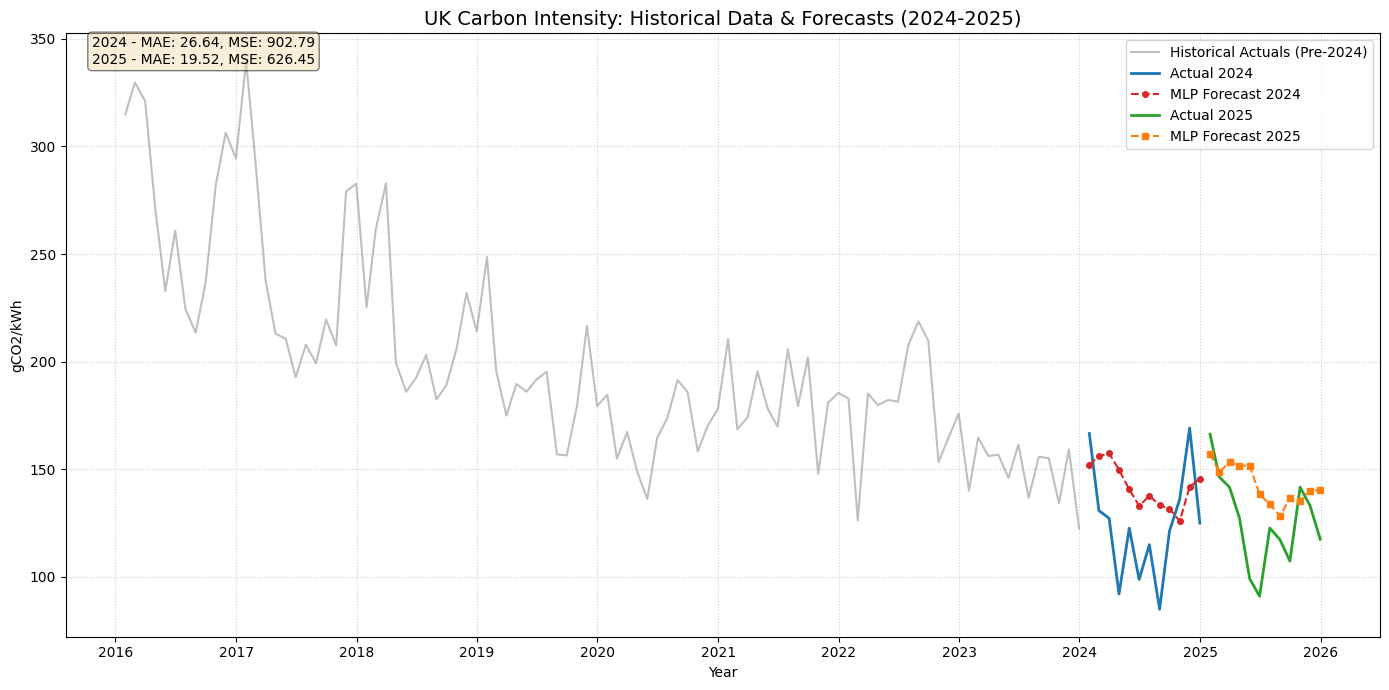

In [15]:
with PowerMonitor(filename = 'full_MLP.csv') as pmon:
    start_time = time.time()
    y_pred_val_scaled = mlp.predict(X_val_scaled)
    # Convert back from scaled units to gCO2/kWh
    y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

    y_pred_test_scaled = mlp.predict(X_test_scaled)
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

    # Calculate metrics for validation and test sets
    val_mse = mean_squared_error(y_val, y_pred_val)
    val_mae = mean_absolute_error(y_val, y_pred_val)

    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    plt.figure(figsize=(14, 7))

    plt.plot(train_data['DATETIME'], train_data['CARBON_INTENSITY'], 
            color='gray', alpha=0.5, label='Historical Actuals (Pre-2024)')

    plt.plot(valid_data['DATETIME'], valid_data['CARBON_INTENSITY'], 
            color='tab:blue', linewidth=2, label='Actual 2024')

    plt.plot(valid_data['DATETIME'], y_pred_val, 
            color='tab:red', linestyle='--', marker='o', markersize=4, label='MLP Forecast 2024')

    plt.plot(test_data['DATETIME'], test_data['CARBON_INTENSITY'], 
            color='tab:green', linewidth=2, label='Actual 2025')

    plt.plot(test_data['DATETIME'], y_pred_test, 
            color='tab:orange', linestyle='--', marker='s', markersize=4, label='MLP Forecast 2025')

    plt.title('UK Carbon Intensity: Historical Data & Forecasts (2024-2025)', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('gCO2/kWh')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)

    # Add metrics text box
    metrics_text = f"2024 - MAE: {val_mae:.2f}, MSE: {val_mse:.2f}\n2025 - MAE: {test_mae:.2f}, MSE: {test_mse:.2f}"
    plt.text(0.02, 0.95, metrics_text, 
            fontsize=10, color='black', transform=plt.gca().transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()
    execution_times['monthly forecast and plot'] = time.time() - start_time
power_stats["monthly forecast and plot"] = pmon.stats()

In [16]:
# Print power usage summary
print("\nPOWER USAGE SUMMARY")
for task, stats in power_stats.items():
    print(f"{task}: {stats}")

# Calculate and print total energy used by the program
print("\n" + "="*50)
print("TOTAL ENERGY USED (Average Power  Runtime)")
print("="*50)

total_energy_joules = 0
for task, stats in power_stats.items():
    if stats and task in execution_times:
        # Sum up average power from all components (CPU Package, CPU Cores, CPU Memory, CPU Platform, GPU Power)
        total_avg_power = 0
        for component, data in stats.items():
            if isinstance(data, dict) and 'avg' in data:
                total_avg_power += data['avg']
        
        runtime = execution_times[task]
        energy = total_avg_power * runtime  # Energy in Joules = Power (Watts)  Time (seconds)
        total_energy_joules += energy
        print(f"{task}: {total_avg_power:.2f}W × {runtime:.4f}s = {energy:.2f}J")

print(f"\nTotal Energy Used: {total_energy_joules:.2f} Joules")
print(f"Total Energy Used: {total_energy_joules/1000:.4f} kJ (kilojoules)")
print("="*50)


POWER USAGE SUMMARY
Data Processing: None
Feature Engineering: {'CPU Package': {'min': 15.094965934753418, 'max': 22.355356216430664, 'avg': 19.082908868789673, 'samples': 4}, 'CPU Cores': {'min': 9.463987350463867, 'max': 18.484596252441406, 'avg': 15.159079551696777, 'samples': 4}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 4}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 4}, 'GPU Power': {'min': 0.010672659613192081, 'max': 0.015984082594513893, 'avg': 0.01288080820813775, 'samples': 4}}
Data Splitting: None
Scaling: None
Model Training: {'CPU Package': {'min': 9.985604286193848, 'max': 18.24271583557129, 'avg': 13.181043709380717, 'samples': 79}, 'CPU Cores': {'min': 6.403425693511963, 'max': 15.638093948364258, 'avg': 9.508784680426876, 'samples': 79}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 79}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 79}, 'GPU Power': {'min': 0.013165284879505634, 'max': 0.17583